### DIGS 20006/30006 NLP - Final Project 
**Shuting Chen**

In [310]:
import pandas as pd
import numpy as np
import re, glob, os
import jieba
from collections import defaultdict
from operator import itemgetter
from sklearn.manifold import TSNE

import nltk
import spacy
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors

%matplotlib inline

In [2]:
# Define emojis and punctuation to be deleted 
pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\u200b\u3000\U0001f92a●\\≧▽≦/⁎⁍̴̛ᴗ⁍̴̛⁎´;︵;`#\(～(･ω･)【】a\'-《》🤓✌✋☹:：♥“”~ง •̀_•́ง♡☃☁️✊🤔❤✨☝｀˘˘☝⭐\[]+", 
                     flags=re.UNICODE)

In [3]:
def save_file(filename, contents):  
    fh = open(filename, 'w')  
    fh.write(contents)  
    fh.close()   

In [4]:
# directory containing all hot comments 
data_dir="/Users/shuting/Winter_2019/DIGS 20006/Final_Project/Hot_Comments/"
os.chdir(data_dir)

path = "/Users/shuting/Winter_2019/DIGS 20006/Final_Project/Cleaned_comments_HC/"

HC = list()
sum_chars_HC = 0 
for filename in glob.glob("*.txt"):
    filedata = open(filename, 'r').read()
    filedata = pattern.sub(r'', filedata)
    save_file(path + filename[:-4] + '_cleaned.txt', filedata) 
    sum_chars_HC += len(filedata)
    HC = HC + filedata.split("\n")

In [5]:
# Total chars in hot comments 
sum_chars_HC

43686

In [6]:
# directory containing all normal comments 
data_dir="/Users/shuting/Winter_2019/DIGS 20006/Final_Project/Comments/"
os.chdir(data_dir)

path = '/Users/shuting/Winter_2019/DIGS 20006/Final_Project/Cleaned_comments_new/'
NC = list()
sum_chars_NC = 0 
for filename in glob.glob("*.txt"):
    filedata = open(filename, 'r').read()
    filedata = pattern.sub(r'', filedata)
    save_file(path + filename[:-4] + '_cleaned.txt', filedata) 
    sum_chars_NC += len(filedata)
    NC = NC + filedata.split("\n")

In [7]:
sum_chars_NC

1881777

/Users/shuting/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


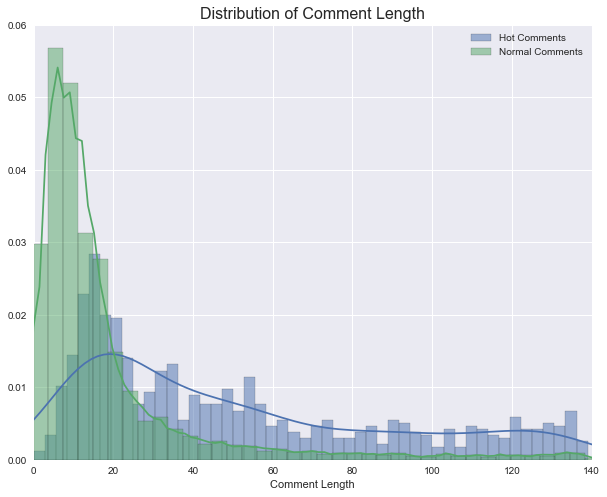

In [311]:
# Length distribution 
sns.set(style="darkgrid")
length_HC = [len(c) for c in HC]
length_NC = [len(c) for c in NC]
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.5}

fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(length_HC, bins=50, label='Hot Comments', hist_kws=hist_kws)
sns.distplot(length_NC, label='Normal Comments', hist_kws=hist_kws)
ax.set_title('Distribution of Comment Length', fontsize=16)
ax.set_xlabel('Comment Length')
ax.legend()
plt.xlim(0, 140)
plt.ylim(0, 0.06)
plt.show()

In [9]:
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords 
stopwords = stopwordslist('/Users/shuting/Winter_2019/DIGS 20006/Final_Project/stopwords_zh.txt')

In [61]:
def remove_stopwords(text, stopwrds):
    tokenList = []
    token_list = jieba.cut(text)
    token_list = "/".join(token_list).split("/")
    for t in token_list:
        if t not in stopwrds:
            tokenList.append(t)
    return " ".join(tokenList)

text_HC_nostopwords = remove_stopwords("".join(HC), stopwords) # string # try " " instead? 
text_NC_nostopwords = remove_stopwords("".join(NC), stopwords)

/Users/shuting/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


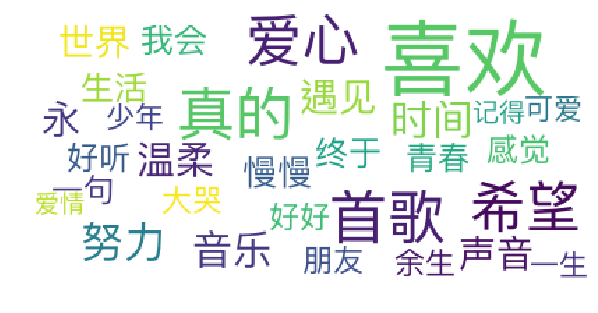

In [308]:
wc = WordCloud(
        background_color="white", 
        max_words=30,
        max_font_size=60,
        random_state=42,
        prefer_horizontal=1.0,
        font_path="/System/Library/fonts/PingFang.ttc",
        collocations=False).generate(text_HC_nostopwords)

plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

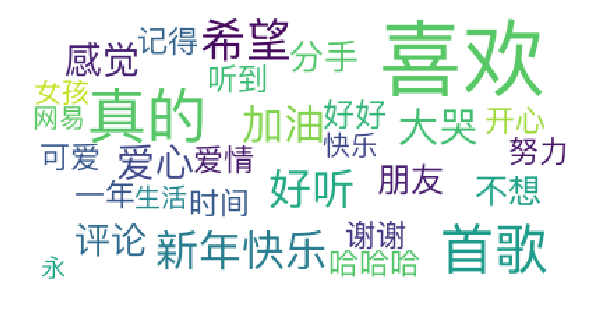

In [12]:
wc = WordCloud(
        background_color="white", 
        max_words=30,
        max_font_size=60,
        random_state=42,
        prefer_horizontal=1.0,
        font_path="/System/Library/fonts/PingFang.ttc",
        collocations=False).generate(text_NC_nostopwords)

plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

#### The second way of creating word clouds - using function WordCloud().generate_from_frequencies()

In [13]:
# Create dictionary of tokens and their frequencies
tokens_cnt_HC_nostopwds = defaultdict(int)  
for c in HC:
    token_list = jieba.cut(c)
    for t in token_list:
        if t not in stopwords:
            tokens_cnt_HC_nostopwds[t] += 1

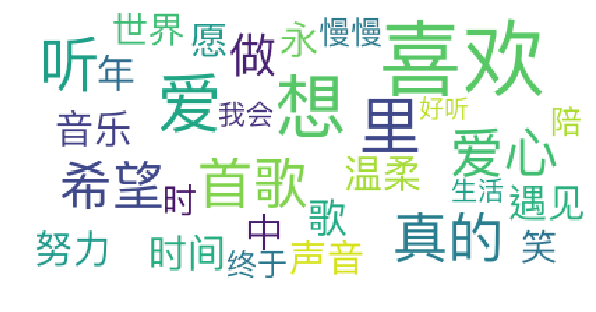

In [14]:
# Word cloud - after removing stopwords, HC
wc = WordCloud(
        background_color="white", 
        max_words=30,
        max_font_size=60,
        random_state=42,
        prefer_horizontal=1.0,
        font_path="/System/Library/fonts/PingFang.ttc"
        ).generate_from_frequencies(tokens_cnt_HC_nostopwds)

plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [15]:
# Create dictionary of tokens and their frequencies
tokens_cnt_NC_nostopwds = defaultdict(int)
for c in NC:
    token_list = jieba.cut(c)
    for t in token_list:
        if t not in stopwords:
            tokens_cnt_NC_nostopwds[t] += 1

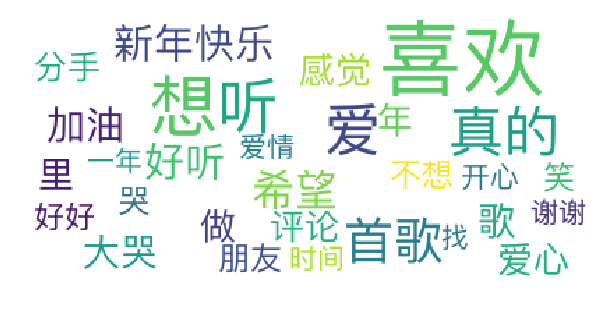

In [16]:
# Word cloud - after removing stopwords, NC
wc = WordCloud(
        background_color="white", 
        max_words=30,
        max_font_size=60,
        random_state=42,
        prefer_horizontal=1.0,
        font_path="/System/Library/fonts/PingFang.ttc"
        ).generate_from_frequencies(tokens_cnt_NC_nostopwds)

plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

### LDA models 

In [18]:
# directory containing all hot comments 
data_dir="/Users/shuting/Winter_2019/DIGS 20006/Final_Project/Cleaned_comments_HC/"
os.chdir(data_dir)

HC_chunks = list()
for filename in glob.glob("*.txt"):
    filedata = open(filename, 'r').read() # string 
    filedata = [filedata.replace("\n", " ")]
    HC_chunks = HC_chunks + filedata

In [19]:
# directory containing all normal comments 
data_dir="/Users/shuting/Winter_2019/DIGS 20006/Final_Project/Cleaned_comments_new/"
os.chdir(data_dir)

NC_chunks = list()
for filename in glob.glob("*.txt"):
    filedata = open(filename, 'r').read() # string 
    filedata = [filedata.replace("\n", " ")]
    NC_chunks = NC_chunks + filedata

In [20]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)  

In [21]:
data_HC = [" ".join(jieba.cut(s)) for s in HC_chunks]
data_NC = [" ".join(jieba.cut(s)) for s in NC_chunks]
data_HC_words = list(sent_to_words(data_HC))
data_NC_words = list(sent_to_words(data_NC))

In [22]:
# Build the bigram and trigram models
# Hot Comments 
bigram_HC = gensim.models.Phrases(data_HC_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_HC = gensim.models.Phrases(bigram_HC[data_HC_words], threshold=100)  
bigram_HC_mod = gensim.models.phrases.Phraser(bigram_HC)
trigram_HC_mod = gensim.models.phrases.Phraser(trigram_HC)
# Normal Comments 
bigram_NC = gensim.models.Phrases(data_NC_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_NC = gensim.models.Phrases(bigram_NC[data_NC_words], threshold=100)  
bigram_NC_mod = gensim.models.phrases.Phraser(bigram_NC)
trigram_NC_mod = gensim.models.phrases.Phraser(trigram_NC)

In [23]:
def processing_words(texts, stop_words, bigram_mod, trigram_mod):
    """Remove stopwords, form bigrams and trigrams """
    text = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    text = [bigram_mod[doc] for doc in text]
    text = [trigram_mod[bigram_mod[doc]] for doc in text]    
    return text

In [109]:
stopwords_new = stopwords + ["喜欢", "真的", "首歌", "爱心", "希望"]

In [25]:
data_HC_ready = processing_words(data_HC_words, stopwords_new, bigram_HC, trigram_HC)
data_NC_ready = processing_words(data_NC_words, stopwords_new, bigram_NC, trigram_NC)

In [26]:
# Create Dictionary 
id2word_HC = corpora.Dictionary(data_HC_ready)
id2word_NC = corpora.Dictionary(data_NC_ready)

# Create Corpus: Term Document Frequency
corpus_HC = [id2word_HC.doc2bow(text) for text in data_HC_ready] 
corpus_NC = [id2word_NC.doc2bow(text) for text in data_NC_ready] 

In [27]:
# Build LDA model - HC
lda_model_HC = gensim.models.ldamodel.LdaModel(corpus=corpus_HC,
                                           id2word=id2word_HC,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [28]:
# Print the Keywords in topics
pprint(lda_model_HC.print_topics())
doc_lda = lda_model_HC[corpus_HC]

[(0,
  '0.007*"公子" + 0.006*"莫妮卡" + 0.005*"注销" + 0.004*"账号" + 0.004*"温柔" + '
  '0.004*"选择" + 0.004*"谢谢" + 0.003*"微笑" + 0.003*"等待" + 0.003*"算是"'),
 (1,
  '0.006*"幸福" + 0.006*"青春" + 0.005*"声音" + 0.005*"爱情" + 0.005*"听到" + 0.004*"哑巴" '
  '+ 0.004*"我会" + 0.004*"永远" + 0.004*"有人" + 0.004*"心碎"'),
 (2,
  '0.005*"纸短情长" + 0.004*"主播" + 0.004*"绝代_风华" + 0.004*"故事" + 0.004*"天下" + '
  '0.004*"竹马" + 0.004*"一年" + 0.003*"姑娘" + 0.003*"那年" + 0.003*"邓紫棋"'),
 (3,
  '0.008*"凉生" + 0.006*"慢慢" + 0.006*"时间" + 0.005*"遇见" + 0.005*"姜生" + 0.004*"朋友" '
  '+ 0.004*"不想" + 0.004*"女孩" + 0.004*"灵魂" + 0.003*"一句"'),
 (4,
  '0.018*"耳朵" + 0.008*"眼睛" + 0.007*"成全" + 0.006*"朱正廷" + 0.005*"男孩" + '
  '0.003*"五年" + 0.003*"第一" + 0.003*"尤长靖" + 0.003*"一句" + 0.003*"沈巍"'),
 (5,
  '0.005*"拥有" + 0.004*"摩天大楼" + 0.004*"夏天" + 0.004*"音乐" + 0.003*"情歌" + '
  '0.003*"忧伤" + 0.003*"思念" + 0.003*"想要" + 0.003*"平凡" + 0.003*"期待"'),
 (6,
  '0.007*"李荣浩" + 0.006*"温暖" + 0.005*"陪伴" + 0.005*"少有" + 0.004*"大哭_大哭" + '
  '0.004*"圣诞快乐" + 0.004*"圣诞" + 0.004*"冯提" + 0.

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_HC.log_perplexity(corpus_HC)) 


Perplexity:  -8.637969254848022


In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_HC, corpus_HC, id2word_HC)  # sort=False ? sort=True
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      25.196594        1       1 -0.137000  0.161339
1      22.936607        1       2 -0.076960 -0.092449
2      13.143974        1       3  0.195026  0.079504
5      11.344207        1       4 -0.002340 -0.056686
0      10.148089        1       5 -0.000316 -0.042916
6       8.701624        1       6  0.006090 -0.009924
4       8.528907        1       7  0.015500 -0.038868, topic_info=     Category       Freq   Term      Total  loglift  logprob
term                                                        
3063  Default  15.000000     耳朵  15.000000  30.0000  30.0000
3768  Default  20.000000     凉生  20.000000  29.0000  29.0000
2533  Default  13.000000     眼睛  13.000000  28.0000  28.0000
371   Default  14.000000     幸福  14.000000  27.0000  27.0000
402   Default  10.000000     男孩  10.000000  26.0000  26.0000
777   Default   7.000000     公子   7.000000  25.0000  25.0000
2754  Default   7.000000    李荣浩   7.000000  24.0000  24.0000
3046  Default   6.000000     成全   6.000000  23.0000  23.0000
382   Default  17.000000     慢慢  17.000000  22.0000  22.0000
3777  Default  12.000000     姜生  12.000000  21.0000  21.0000
3208  Default   5.000000    朱正廷   5.000000  20.0000  20.0000
359   Default  16.000000     声音  16.000000  19.0000  19.0000
4618  Default   6.000000    莫妮卡   6.000000  18.0000  18.0000
561   Default   9.000000     温暖   9.000000  17.0000  17.0000
4190  Default   6.000000   纸短情长   6.000000  16.0000  16.0000
2483  Default  10.000000     哑巴  10.000000  15.0000  15.0000
671   Default  13.000000     听到  13.000000  14.0000  14.0000
2060  Default   8.000000     拥有   8.000000  13.0000  13.0000
1070  Default  15.000000     爱情  15.000000  12.0000  12.0000
364   Default  12.000000     姑娘  12.000000  11.0000  11.0000
1134  Default  16.000000     青春  16.000000  10.0000  10.0000
4653  Default   6.000000     主播   6.000000   9.0000   9.0000
4387  Default   6.000000  绝代_风华   6.000000   8.0000   8.0000
4594  Default   5.000000     注销   5.000000   7.0000   7.0000
1031  Default  11.000000     有人  11.000000   6.0000   6.0000
3305  Default   5.000000   摩天大楼   5.000000   5.0000   5.0000
1517  Default  11.000000     女孩  11.000000   4.0000   4.0000
3175  Default   9.000000    尤长靖   9.000000   3.0000   3.0000
160   Default   9.000000     灵魂   9.000000   2.0000   2.0000
268   Default  19.000000     我会  19.000000   1.0000   1.0000
...       ...        ...    ...        ...      ...      ...
3134   Topic7   1.588537     仙子   2.146498   2.1607  -6.2549
3129   Topic7   1.588537     乐华   2.146498   2.1607  -6.2549
3224   Topic7   1.588537     生于   2.146498   2.1607  -6.2549
3435   Topic7   1.464138     理由   2.022132   2.1388  -6.3365
3383   Topic7   1.464138     假装   2.022132   2.1388  -6.3365
3059   Topic7   1.464085     礼拜   2.022127   2.1388  -6.3365
3035   Topic7   1.456457     夫人   2.020864   2.1342  -6.3418
3061   Topic7   1.456457     穿着   2.020864   2.1342  -6.3418
3258   Topic7   1.450366     陷入   2.021271   2.1298  -6.3459
3169   Topic7   1.450366     如水   2.021271   2.1298  -6.3459
3117   Topic7   1.450366    一朵花   2.021271   2.1298  -6.3459
3392   Topic7   1.370027     原地   2.023380   2.0718  -6.4029
3416   Topic7   1.370027     承诺   2.023380   2.0718  -6.4029
3463   Topic7   1.370027     轻柔   2.023380   2.0718  -6.4029
1518   Topic7   1.873830     奸笑   2.902191   2.0242  -6.0898
2533   Topic7   6.514935     眼睛  13.464783   1.7357  -4.8437
3170   Topic7   2.063613     娱乐   3.408228   1.9600  -5.9933
402    Topic7   4.432849     男孩  10.793055   1.5718  -5.2287
186    Topic7   2.018252     舞台   4.153015   1.7401  -6.0155
1595   Topic7   2.058551     唯独   4.501753   1.6792  -5.9958
3228   Topic7   2.332205     第一   6.690528   1.4078  -5.8709
1900   Topic7   1.947374     人间   4.744307   1.5712  -6.0513
144    Topic7   2.004104     梦想   5.289151   1.4912  -6.0226
3175   Topic7   2.226198    尤长靖   9.297515   1.0323  -5

In [31]:
# Build LDA model - NC
lda_model_NC = gensim.models.ldamodel.LdaModel(corpus=corpus_NC,
                                           id2word=id2word_NC,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [32]:
# Print the Keywords in topics
pprint(lda_model_NC.print_topics())
# doc_lda = lda_model_NC[corpus_NC]

[(0,
  '0.010*"张艺兴" + 0.006*"艺兴" + 0.006*"抄袭" + 0.005*"说法" + 0.005*"不想_其他人_误解" + '
  '0.005*"打歪" + 0.005*"重庆_街读" + 0.005*"加油" + 0.004*"有求于_苍天_必有_出头之日" + '
  '0.004*"好听"'),
 (1,
  '0.000*"胡彦斌" + 0.000*"加油" + 0.000*"好听" + 0.000*"感觉" + 0.000*"大哭" + '
  '0.000*"哈哈哈" + 0.000*"罗志祥" + 0.000*"新年快乐" + 0.000*"评论" + 0.000*"可爱"'),
 (2,
  '0.010*"好听" + 0.008*"弟弟" + 0.007*"大哭" + 0.006*"新年快乐" + 0.006*"许嵩" + '
  '0.005*"公子" + 0.005*"作词_单色_作曲_单色" + 0.005*"记得_这位_歌手" + 0.004*"邓紫棋" + '
  '0.004*"天下"'),
 (3,
  '0.006*"新年快乐" + 0.006*"加油" + 0.006*"大哭" + 0.005*"感觉" + 0.005*"好听" + '
  '0.005*"朋友" + 0.005*"评论" + 0.004*"分手" + 0.004*"好好" + 0.004*"谢谢"'),
 (4,
  '0.010*"哑巴" + 0.005*"无名之辈" + 0.005*"评论" + 0.005*"新年快乐" + 0.004*"大盗" + '
  '0.003*"一条_恶犬" + 0.003*"恶犬" + 0.003*"电影" + 0.003*"姑娘" + 0.003*"生日快乐"'),
 (5,
  '0.012*"尤长靖" + 0.010*"杰哥" + 0.010*"小鬼" + 0.009*"好听" + 0.008*"朱星杰" + '
  '0.007*"陈立农" + 0.007*"朱正廷" + 0.006*"农农" + 0.006*"晚安" + 0.006*"非同"'),
 (6,
  '0.015*"青梅竹马" + 0.008*"女生" + 0.008*"拒绝" + 0.007*"加油" + 0.0

In [33]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_NC.log_perplexity(corpus_NC))  # a measure of how good the model is. lower the better.


Perplexity:  -8.840195527405355


In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_NC, corpus_NC, id2word_NC)  # sort=False ? sort=True
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      71.033005        1       1  0.206131 -0.035001
2      11.675594        1       2  0.027741  0.241677
4       6.918797        1       3  0.143230 -0.042182
6       4.702137        1       4 -0.034299 -0.158755
0       3.665088        1       5 -0.084882  0.012156
5       2.005246        1       6 -0.160021 -0.006230
1       0.000141        1       7 -0.097899 -0.011665, topic_info=      Category         Freq            Term        Total  loglift  logprob
term                                                                      
550    Default  1724.000000              好听  1724.000000  30.0000  30.0000
307    Default  1624.000000              加油  1624.000000  29.0000  29.0000
936    Default   416.000000              晚安   416.000000  28.0000  28.0000
888    Default  1760.000000            新年快乐  1760.000000  27.0000  27.0000
2049   Default   380.000000              女生   380.000000  26.0000  26.0000
311    Default   712.000000              努力   712.000000  25.0000  25.0000
513    Default  1611.000000              大哭  1611.000000  24.0000  24.0000
501    Default   596.000000              声音   596.000000  23.0000  23.0000
1396   Default  1341.000000              评论  1341.000000  22.0000  22.0000
3412   Default   355.000000              弟弟   355.000000  21.0000  21.0000
7925   Default   223.000000            青梅竹马   223.000000  20.0000  20.0000
1168   Default   406.000000              男孩   406.000000  19.0000  19.0000
4506   Default   234.000000              哑巴   234.000000  18.0000  18.0000
428    Default   816.000000             哈哈哈   816.000000  17.0000  17.0000
2384   Default   188.000000             李荣浩   188.000000  16.0000  16.0000
2257   Default   235.000000              拒绝   235.000000  15.0000  15.0000
432    Default   292.000000              哥哥   292.000000  14.0000  14.0000
381    Default   782.000000              可爱   782.000000  13.0000  13.0000
1158   Default   699.000000              生活   699.000000  12.0000  12.0000
82     Default   640.000000              世界   640.000000  11.0000  11.0000
277    Default  1033.000000              分手  1033.000000  10.0000  10.0000
1608   Default   419.000000              音乐   419.000000   9.0000   9.0000
1561   Default   275.000000              长大   275.000000   8.0000   8.0000
17302  Default   236.000000              许嵩   236.000000   7.0000   7.0000
780    Default   512.000000              感情   512.000000   6.0000   6.0000
1004   Default   570.000000              歌词   570.000000   5.0000   5.0000
6238   Default   190.000000              等待   190.000000   4.0000   4.0000
607    Default   161.000000              宝贝   161.000000   3.0000   3.0000
2707   Default   286.000000              表白   286.000000   2.0000   2.0000
3090   Default   200.000000              公子   200.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
13916   Topic7     0.000012             胡彦斌    61.756187  -1.9577 -10.5097
307     Topic7     0.000012              加油  1624.962158  -5.2288 -10.5107
550     Topic7     0.000012              好听  1724.701904  -5.2889 -10.5113
782     Topic7     0.000012              感觉  1447.865112  -5.1140 -10.5113
513     Topic7     0.000012              大哭  1611.947144  -5.2214 -10.5114
428     Topic7     0.000012             哈哈哈   816.561829  -4.5415 -10.5116
11288   Topic7     0.000012             罗志祥    26.076542  -1.0975 -10.5116
888     Topic7     0.000012            新年快乐  1760.819336  -5.3100 -10.5116
1396    Topic7     0.000012              评论  1341.998779  -5.0385 -10.5117
381     Topic7     0.000012              可爱   782.808167  -4.4995 -10.5118
82      Topic7     0.000012              世界   640.240417  -4.2985 -10.5118
13606   Topic7     0.000012  感情_从来不_拖泥带水_情歌    18.220264  -0.7392 -10.5118
1158    Topic7     0.000012              生活   699.363159  -4.3868 -10.5118
555     Topic7     0.

### Clustering 

In [86]:
# First, combine hot comments and normal comments for each song 
path1 = "/Users/shuting/Winter_2019/DIGS 20006/Final_Project/Cleaned_comments_HC/"
path2 = "/Users/shuting/Winter_2019/DIGS 20006/Final_Project/Cleaned_comments_new/"
song_totalcomments = {}
os.chdir(path1)

for filename in glob.glob("*.txt"):
    filedata = open(filename, 'r').read()
    filedata = filedata.split("\n") # list of strings 
    filedata = "".join(filedata)
    song_totalcomments[filename[:-15]] = filedata

os.chdir(path2)

for filename in glob.glob("*.txt"):
    filedata = open(filename, 'r').read()
    filedata = filedata.split("\n") # list of strings 
    filedata = "".join(filedata) # string
    song_totalcomments[filename[:-12]] = song_totalcomments[filename[:-12]] + " " + filedata

In [110]:
stopwords_new = stopwords_new + ["大哭", "加油", "爱", "想", "听", "歌", "新年快乐"]

In [111]:
# Get tokens for the whole corpus, after removing stopwords 
comments_tokens = {}
for k, v in song_totalcomments.items():
    song_comments = remove_stopwords(v, stopwords_new)
    song_comments = song_comments.split(" ")
    comments_tokens[k] = song_comments

In [170]:
# Find 8 most frequently used words to represent each song without including some not common names or characters
names = ["王琳凯", "润玉", "旭凤", "锦觅", "艾热", "尤长靖", "朱星杰", "朱正廷", "陈立农", "ヽ", "街读", "李荣浩", "胡广生"]
five_words = {}
for k, v in comments_tokens.items():
    tokens_freq = defaultdict(int)
    for token in v:
        tokens_freq[token] += 1
    eight_wds_list = sorted(tokens_freq.items(), key=itemgetter(1), reverse=True)[:15]
    eight_wds_list = [w[0] for w in eight_wds_list if w[0] not in names][:8]
    eight_words[k] = eight_wds_list

In [171]:
eight_words

{'GOOD NIGHT': ['小鬼', '晚安', '宝贝', '好听', '鬼', '抽烟', '出道', '鬼哥'],
 'The Way I Am': ['猹', '好听', '演唱会', '可爱', '流泪', '粉', '前奏', '大笑'],
 'Way Back Home': ['高级', '第二个', '封面', '时', '哭', '在劫难逃', '南韩', '字'],
 "When It's Christmas": ['张艺兴', '艺兴', '好听', '努力', '粉丝', '温暖', '黑', '音乐'],
 '一个人去巴黎': ['巴黎', '人去', '好像', '挺', '好听', '分手', '例外', '每次'],
 '一生等你': ['公子', '晚媚', '长安', '错', '月影', '小说', '无疆', '剧'],
 '不染': ['凤凰', '觅', '锦', '心疼', '毛', '不染', '哭', '不易'],
 '世本常态': ['出头之日', '苍天', '必有', '有求于', '祝', '黑胶', '年纪', '朋友'],
 '买条街': ['乖', '重庆', '话', '打歪', '买条', '抄袭', '说法', '不想'],
 '佛系少女': ['佛系', '冯提', '好听', '生理期', '剁', '鸡', '少女', '歌词'],
 '你是我最愚蠢的一次浪漫': ['浪漫', '愚蠢', '做', '生活', '笑', '哭', '分手', '吹散'],
 '你要的全拿走': ['分手', '胡彦斌', '感觉', '哭', '情歌', '哈哈哈', '感情', '难受'],
 '侧脸': ['唯一', '特别', '取消', '故事', '做', '男孩子', '关注', '评论'],
 '倒数': ['倒数', '邓紫棋', '别无所求', '好好', '好听', '感觉', '时间', '珍惜'],
 '光年之外（热爱版）': ['好听', '邓紫棋', '大笑', '之外', '光年', '版本', '翻唱', '原唱'],
 '凌晨三点（demo）': ['凌晨', '三点', '醒来', '想起', '重逢', '分手', '遇见', '夜里'],
 '出山': ['奸笑

In [143]:
# Load a well-trained Chinese Word2Vec model 
from gensim.models import KeyedVectors
path3 = "/Volumes/BENQ DP610/NLP/baike_26g_news_13g_novel_229g.bin"
chinese_word2vec_model = KeyedVectors.load_word2vec_format(path3, binary=True)
vocab = list(chinese_word2vec_model.wv.vocab.keys())
print(vocab[:10])
# Print the total number of items in the model 
print(len(chinese_word2vec_model.wv.vocab))

['的', '了', '是', '在', '他', '我', '你', '也', '她', '就']
6400505


In [182]:
# Get word vector for each song and prepare the whole word vector matrix 
song_list = []
dimension = 8*128
word_vectors = np.zeros((56, dimension))

for k, v in eight_words.items():
    song_list.append(k)
    word_vectors[len(song_list)-1, :] = chinese_word2vec_model[v].reshape(1, dimension)

In [183]:
# Dimension reduction - using t-SNE: 2 dimensions
word_vectors_embedded = TSNE(n_components=2).fit_transform(word_vectors)

In [186]:
# K-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(word_vectors_embedded)
y_kmeans = kmeans.predict(word_vectors_embedded)

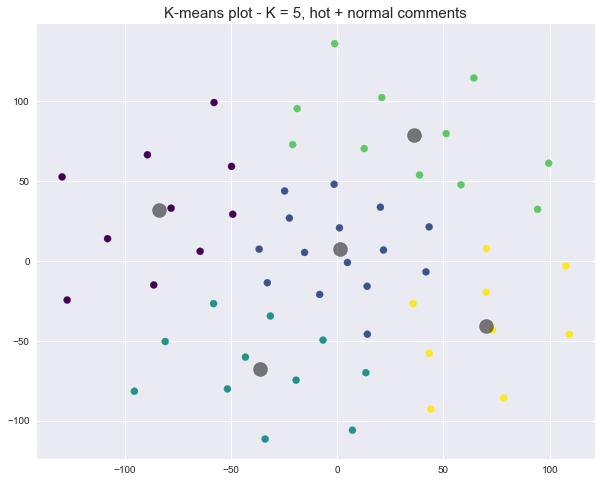

In [190]:
# Visualization 
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_embedded[:, 0], word_vectors_embedded[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title("K-means plot - K = 5, hot + normal comments", size=15)
plt.show()

In [193]:
# Identify songs in each group 
d = {"songs": song_list, "labels":kmeans.labels_}
df_song_labels = pd.DataFrame(d)
df_song_labels.head()

,labels,songs
0,1,GOOD NIGHT
1,4,The Way I Am
2,0,Way Back Home
3,1,When It's Christmas
4,2,一个人去巴黎


In [214]:
labels = df_song_labels["labels"].unique()
song_clusters = {}
for label in labels:
    song_clusters["cluster" + str(label)] = list(df_song_labels[df_song_labels["labels"] == label].songs.values)

song_clusters

{'cluster0': ['Way Back Home',
  '侧脸',
  '天份',
  '心事',
  '慢慢喜欢你',
  '爱了很久的朋友',
  '盗将行',
  '给陌生人的你听',
  '耳朵',
  '陷阱'],
 'cluster1': ['GOOD NIGHT',
  "When It's Christmas",
  '一生等你',
  '世本常态',
  '佛系少女',
  '光年之外（热爱版）',
  '出山',
  '可不可以',
  '喜新恋旧',
  '戒烟（live）',
  '时间飞行',
  '昨日青空',
  '目不转睛',
  '绝代风华',
  '说书人'],
 'cluster2': ['一个人去巴黎',
  '你是我最愚蠢的一次浪漫',
  '去年夏天',
  '哑巴',
  '圣诞夜',
  '往后余生',
  '星球坠落',
  '最美的期待',
  '胡广生',
  '莫妮卡',
  '青梅竹马'],
 'cluster3': ['不染',
  '买条街',
  '你要的全拿走',
  '倒数',
  '可能否',
  '成全',
  '摩天大楼',
  '最暖的忧伤',
  '浪人琵琶',
  '纸短情长',
  '起风了'],
 'cluster4': ['The Way I Am',
  '凌晨三点（demo）',
  '只要平凡',
  '台北某个地方',
  '年少有为',
  '忽而今夏',
  '我们',
  '最美的遇见',
  '醒着醉']}

In [218]:
# Combine all comments in a single cluster for 5 clusters 
comments_by_cluster = {}
for k, v in song_clusters.items():
    comments = ""
    for song in v:
        comments = comments + song_totalcomments[song] 
    comments_by_cluster[k] = comments

In [138]:
# Sentiment Analysis using TextBlob
import textblob
from textblob import TextBlob
import jieba.analyse

In [250]:
# Extract tags based on TF-IDF
tags_by_cluster  = {}
for k, v in comments_by_cluster.items():
    tags = jieba.analyse.extract_tags(v, topK=60, withWeight=False, allowPOS=())
    # print(len(tags))
    tags_by_cluster[k] = [tag for tag in tags if tag not in stopwords_new][:20]

In [259]:
print(tags_by_cluster)

{'cluster1': ['好听', '晚媚', '哈哈哈', '尤长靖', '镇魂', '评论', '歌词', '公子', '许嵩', '邓紫棋', '张艺兴', '感觉', '奸笑', '啊啊啊', '晚安', '网易', '男孩', '开心', '大笑', '出头之日'], 'cluster4': ['凉生', '姜生', '遇见', '抑郁症', '分手', '好听', '少有', '凌晨', '活下去', '遗憾', '感觉', '三点', '快乐', '开心', '不想', '电影', '患者', '天佑', '平凡', '流泪'], 'cluster0': ['慢慢', '耳朵', '朋友', '分手', '评论', '开心', '不想', '爱情', '恶犬', '好听', '难过', '天份', '我会', '谢谢', '陌生人', '心碎', '幸福', '感觉', '快乐', '好好'], 'cluster2': ['分手', '余生', '哑巴', '任性', '好听', '男生', '青梅竹马', '往后', '无名之辈', '评论', '一年', '爱情', '莫妮卡', '哈哈哈', '期待', '好好', '摘下', '长大', '丧丧', '开心'], 'cluster3': ['好听', '单色', '润玉', '成全', '感觉', '原版', '评论', '谢谢', '歌手', '打歪', '分手', '作词', '记得', '哈哈哈', '不想', '流泪', '旭凤', '网易', '摩天大楼', '歌词']}


In [254]:
# Sentiment analysis based on extracted tags for each cluster 
sentiment_by_cluster = {}
for k, v in tags_by_cluster.items():
    sum_polarity = 0
    sum_subjectivity = 0
    for tag in v:
        chinese_blob = TextBlob(tag)
        en_blob = chinese_blob.translate(from_lang="zh-CN", to='en') # Need to translate Chinese into English 
        sum_polarity += en_blob.sentiment.polarity
        sum_subjectivity += en_blob.sentiment.subjectivity
    avg_pol = sum_polarity/len(v)
    avg_sub = sum_subjectivity/len(v)
    sentiment_by_cluster[k] = {"Average polarity": avg_pol, "Average subjectivity": avg_sub}

In [255]:
sentiment_by_cluster

{'cluster0': {'Average polarity': 0.125, 'Average subjectivity': 0.36},
 'cluster1': {'Average polarity': 0.155, 'Average subjectivity': 0.2475},
 'cluster2': {'Average polarity': 0.09125,
  'Average subjectivity': 0.24500000000000002},
 'cluster3': {'Average polarity': 0.06874999999999999,
  'Average subjectivity': 0.1075},
 'cluster4': {'Average polarity': 0.14681818181818182,
  'Average subjectivity': 0.27249999999999996}}

In [314]:
print(tags_by_cluster["cluster3"])

['好听', '单色', '润玉', '成全', '感觉', '原版', '评论', '谢谢', '歌手', '打歪', '分手', '作词', '记得', '哈哈哈', '不想', '流泪', '旭凤', '网易', '摩天大楼', '歌词']


In [269]:
# Sentiment analysis according to seven groups (i.e. 乐，好，怒，愁，惊，恶，惧)of emotional words 
le = ["快乐", "安心", "乐", "开心", "高兴", "大笑", "笑", "呵呵", "哈哈哈", "快乐", "哈", "哈哈", "哈哈哈哈"] # 乐
hao = ["赞扬", "喜爱", "感动", "好听", "喜欢", "爱"] # 好
nu = ["怒", "愤怒", "发火", "生气", "发脾气", "怒吼", "得罪", "吊炸", "气炸", "吼吼"] # 怒
chou = ["悲伤", "失望", "愧疚", "郁闷", "尴尬", "无奈", "难过", "自责", "莫名", "嘲讽", "孤单", "孤独", "寂寞", "痛心", "流泪"] # 愁
jing = ["惊", "震惊", "哇塞", "压惊", "奇怪", "看起来", "惊讶", "惊艳"] # 惊
wu = ["厌恶", "贬责", "烦", "讽刺", "讨厌", "恶心", "嫌弃", "有毒", "诅咒", "装逼", "恶意", "得罪", "打架", "不能"] # 恶
ju = ["慌", "恐惧", "怕", "担心", "吓人", "叹气", "闭嘴", "不想", "害怕"] # 惧 

In [266]:
# Get tokens for comments in each group
tokens_by_cluster = {}
for k, v in comments_by_cluster.items():
    song_comments = remove_stopwords(v, stopwords)
    song_comments = song_comments.split(" ")
    tokens_by_cluster[k] = song_comments

In [289]:
sentiment_counts = {"cluster": [], "le": [], "hao": [], "nu": [], "chou": [], "jing": [], "wu": [], "ju": []}
for k, v in tokens_by_cluster.items():
    sentiment_counts["cluster"].append(k)
    le_sum = 0 
    hao_sum = 0 
    nu_sum = 0 
    chou_sum = 0
    jing_sum = 0
    wu_sum = 0
    ju_sum = 0
    for token in v:
        if token in le:
            le_sum += 1
        elif token in hao:
            hao_sum += 1
        elif token in nu:
            nu_sum += 1
        elif token in chou:
            chou_sum += 1
        elif token in jing:
            jing_sum += 1
        elif token in wu:
            wu_sum += 1
        elif token in ju:
            ju_sum += 1
            
    sentiment_counts["le"].append(le_sum)     
    sentiment_counts["hao"].append(hao_sum)  
    sentiment_counts["nu"].append(nu_sum)  
    sentiment_counts["chou"].append(chou_sum)  
    sentiment_counts["jing"].append(jing_sum)  
    sentiment_counts["wu"].append(wu_sum)  
    sentiment_counts["ju"].append(ju_sum)  

In [302]:
df_sa = pd.DataFrame(sentiment_counts)
cols_order = ['cluster', 'le', 'hao', 'nu', 'chou', 'jing', 'wu', 'ju']
df_sa = df_sa[cols_order]
df_sa

,cluster,le,hao,nu,chou,jing,wu,ju
0,cluster1,1395,3546,30,444,86,82,241
1,cluster4,718,1958,35,524,41,50,301
2,cluster0,1075,3801,25,592,45,119,370
3,cluster2,1018,3060,48,547,65,97,278
4,cluster3,889,3264,20,566,62,188,380


/Users/shuting/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


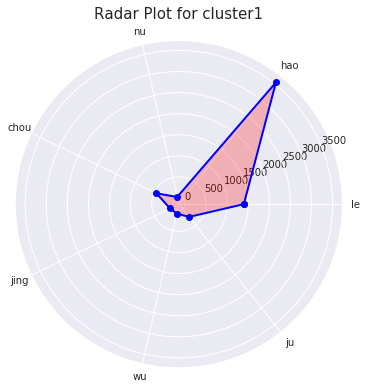

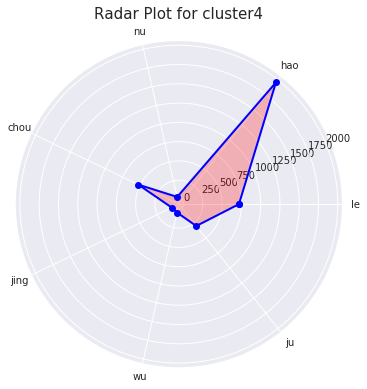

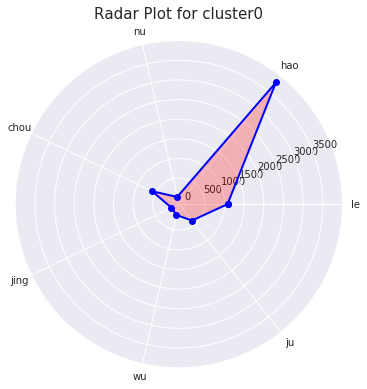

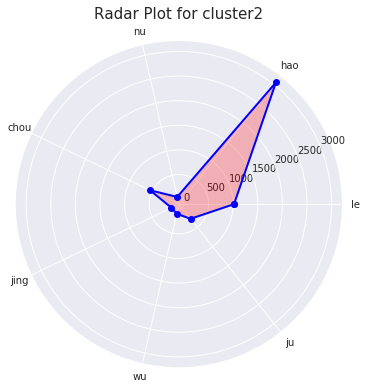

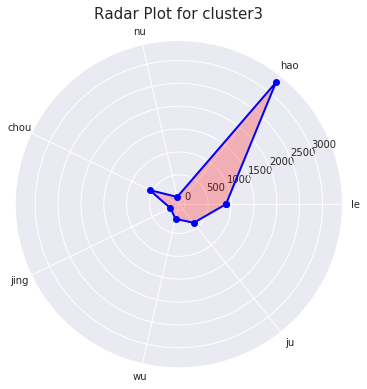

In [307]:
seven_labels = df_sa.columns.values[1:]
num_labels = df_sa.shape[1] - 1
for i in range(len(df_sa)): 
    data = df_sa.iloc[i, 1:]
    angles = np.linspace(0, 2*np.pi, num_labels, endpoint=False) 
    data = np.concatenate((data, [data[0]])) 
    angles = np.concatenate((angles, [angles[0]])) 

    plt.figure(figsize=(8, 6)) 
    plt.polar(angles, data, 'bo-', linewidth=2) 
    plt.thetagrids(angles * 180/np.pi, seven_labels) 
    plt.fill(angles, data, facecolor='r', alpha=0.25)
    plt.title("Radar Plot for {}".format(df_sa.cluster[i]), fontsize = 15)
    plt.show()